# Studying members of the CD_X community

In [439]:
import reframed
import pandas as pd

import copy
sys.path.append("../functions/")
import EGC

In [381]:
model_uni = reframed.load_cbmodel("../input/universe_bacteria.xml")

## Caproiciproducens CH14-bin.0

### Model before Rnf addition

In [382]:
model = reframed.load_cbmodel("../output/Caproicproducens_CH14_bin_0/CH14-bin.0_acetate.xml")

media_db = pd.read_csv("https://raw.githubusercontent.com/cdanielmachado/carveme/master/carveme/data/input/media_db.tsv",sep="\t")

In [383]:
model.get_objective()

{'R_Growth': 1.0}

#### Model grows on LB medium

In [384]:
LB_env = reframed.Environment.from_compounds(media_db[media_db.medium=="LB[-O2]"].compound.values)
LB_env.pop("R_EX_glc__D_e")

(-10.0, inf)

In [385]:
sol = reframed.pFBA(model)
lb_media_min_growth = sol.values["R_Growth"]
lb_media_but_prod = sol.values["R_EX_but_e"]

In [386]:
lb_media_min_growth

51.23134538636119

In [387]:
lb_media_but_prod

0.0

**LB medium with different carbon sources**

In [388]:
carbon_sources = ["glc__D","xyl__D","lac__L","etoh","glyc","glyald","gcald"]

In [389]:
results_lb = {}

for met in carbon_sources:
    results_lb[met]={}
    
    LB_env_cp = LB_env.copy()
    LB_env_cp["R_EX_"+met+"_e"]=(-10,0)
    LB_env_cp.apply(model,warning=False,inplace=True)

    sol = reframed.pFBA(model)
    results_lb[met]["growth increase %"]=(sol.values["R_Growth"]/lb_media_min_growth)*100
    results_lb[met]["but. prod. mmol/g*h"]=sol.values["R_EX_but_e"]

In [390]:
pd.DataFrame(results_lb).T

,growth increase %,but. prod. mmol/g*h
glc__D,2.393139,4.625224
xyl__D,2.139643,4.135294
lac__L,1.586974,3.067148
etoh,1.413816,2.732484
glyc,1.914511,3.700179
glyald,1.914511,3.700179
gcald,1.704447,3.294188


#### Model cannot grow on M9

In [391]:
M9_env = reframed.Environment.from_compounds(media_db[media_db.medium=="M9[-O2]"].compound.values)

M9_env.apply(model,warning=False,inplace=True)

reframed.pFBA(model).show_values(pattern="R_EX_",sort=True,abstol=1e-2)

#### Model grows on gapfill medium

In [392]:
gapfill_media = pd.read_csv("../output/gapfill_media/gapfill_media.tsv",sep="\t")

In [393]:
gapfill_env = reframed.Environment.from_compounds(gapfill_media[gapfill_media.medium=="CD_X"].compound.values)
gapfill_env.apply(model,warning=False,inplace=True)
reframed.pFBA(model).values["R_Growth"]

0.7361855110924663

#### Model grows on SynCon1 medium

In [394]:
media_db_constrained = pd.read_csv("../output/steadiercom_sample_0.1.3/media_db_constrained.tsv",sep="\t")

constrained_medium_env = reframed.Environment.from_compounds(media_db_constrained[media_db_constrained.medium=="SC2_X"].compound.values)

SC1_X = media_db_constrained[media_db_constrained.medium=="SC1_X"].copy()
bound_dict = SC1_X[["compound","bound"]].set_index("compound",drop=True)["bound"].to_dict()

for met, bound in bound_dict.items():
    constrained_medium_env["R_EX_"+met+"_e"]=(-bound,1000)

In [395]:
constrained_medium_env.apply(model,warning=False,inplace=True)
sol = reframed.pFBA(model)
sol.values["R_Growth"]

9.314899704799626e-05

## Comparing different models and production potential

In [482]:
import seaborn as sns
def plot_production(model,RNF=True):

    constrained_medium_env.apply(model,warning=False,inplace=True)
    sol = reframed.pFBA(model)
    sol.values["R_Growth"]

    SC1_media_min_growth = sol.values["R_Growth"]
    SC1_media_but_prod = sol.values["R_EX_but_e"]
    SC1_media_hxa_prod = sol.values["R_EX_hxa_e"]
    SC1_media_R_BCD1= sol.values["R_BCD1"]
    SC1_media_R_ATPS4rpp = sol.values["R_ATPS4rpp"]

    default_prod = {"SC1_media_min_growth":SC1_media_min_growth,
                    "SC1_media_but_prod":SC1_media_but_prod,
                    "SC1_media_hxa_prod":SC1_media_hxa_prod,
                    "SC1_media_R_BCD1":SC1_media_R_BCD1,
                    "SC1_media_R_ATPS4rpp":SC1_media_R_ATPS4rpp}

    if RNF:
        SC1_media_R_RnfH2_2 = sol.values["R_RnfH2_2"]
        default_prod["SC1_media_R_RnfH2_2"]=SC1_media_R_RnfH2_2

    print(pd.Series(default_prod))

    results_SC1 = {}

    for met in carbon_sources:
        results_SC1[met]={}

        constrained_medium_env_cp = constrained_medium_env.copy()
        constrained_medium_env_cp["R_EX_"+met+"_e"]=(-10,0)
        constrained_medium_env_cp.apply(model,warning=False,inplace=True)

        sol = reframed.pFBA(model)
        print(sol.values["R_EX_hxa_e"])
        sol_fva = reframed.FVA(model,obj_frac=1,reactions=["R_EX_ac_e","R_EX_hxa_e","R_EX_but_e","R_EX_hxa_e"])
        sol_fva_0_9 = reframed.FVA(model,obj_frac=0.9,reactions=["R_EX_ac_e","R_EX_hxa_e","R_EX_but_e","R_EX_hxa_e"])

        results_SC1[met]["pFBA growth frac"]=(sol.values["R_Growth"]/SC1_media_min_growth) 
        results_SC1[met]["BCD1 prod. (mmol/g*h)"]=sol.values["R_BCD1"]
        if RNF:
            results_SC1[met]["RnfH2_2 prod. (mmol/g*h)"]=sol.values["R_RnfH2_2"]
            
        results_SC1[met]["ATPS4rpp prod. (mmol/g*h)"]=sol.values["R_ATPS4rpp"]
        results_SC1[met]["pFBA but.prod. (mmol/g*h)"]=sol.values["R_EX_but_e"]
        results_SC1[met]["pFBA hxa. prod. (mmol/g*h)"]=sol.values["R_EX_hxa_e"]
        results_SC1[met]["FVA max hxa. prod. (mmol/g*h), obj_frac=1"]=sol_fva["R_EX_hxa_e"][1]
        results_SC1[met]["FVA max hxa. prod. (mmol/g*h), obj_frac=0.9"]=sol_fva_0_9["R_EX_hxa_e"][1]


    results_SC1_df = pd.DataFrame(results_SC1).T

    met2name = {met:model_uni.metabolites["M_"+met+"_e"].name for met in carbon_sources}
    results_SC1_df.index = results_SC1_df.index.map(lambda x:met2name[x])
    results_SC1_df



    ax = sns.heatmap(results_SC1_df, vmin=-3, vmax=3,
                     cmap="PiYG", xticklabels=True, yticklabels=True)

SC1_media_min_growth    0.000093
SC1_media_but_prod      0.000000
SC1_media_hxa_prod      0.000000
SC1_media_R_BCD1        0.000000
SC1_media_R_ATPS4rpp    0.000239
dtype: float64
0.0
0.0
0.0
0.0
0.0
0.0
0.0


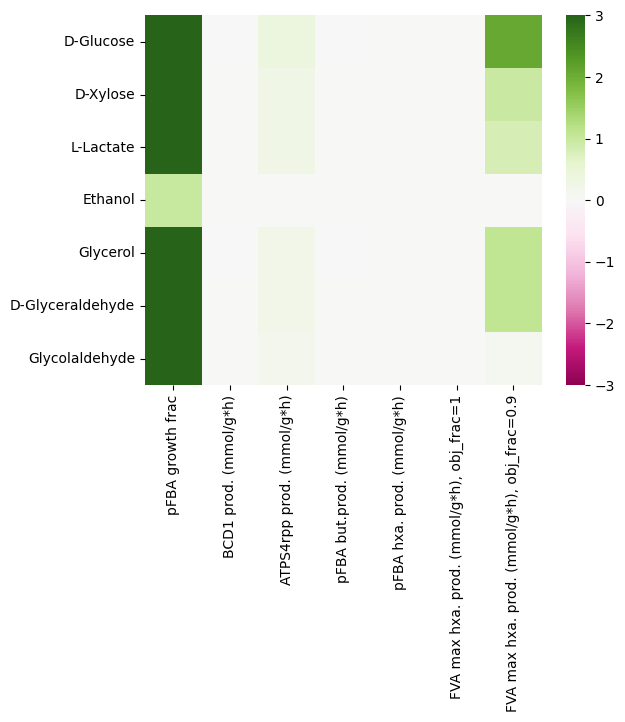

In [483]:
plot_production(model,RNF=False)

### Testing model after adding Rnf and other manipulations

In [484]:
model_new = reframed.load_cbmodel("../output/GEMs/GEMs_final/CH14-bin.0.xml")


SC1_media_min_growth    0.000107
SC1_media_but_prod      0.001179
SC1_media_hxa_prod      0.000000
SC1_media_R_BCD1        0.001179
SC1_media_R_ATPS4rpp    0.002442
SC1_media_R_RnfH2_2     0.009768
dtype: float64
0.0
0.0
0.0
0.0
0.0
0.0
0.0


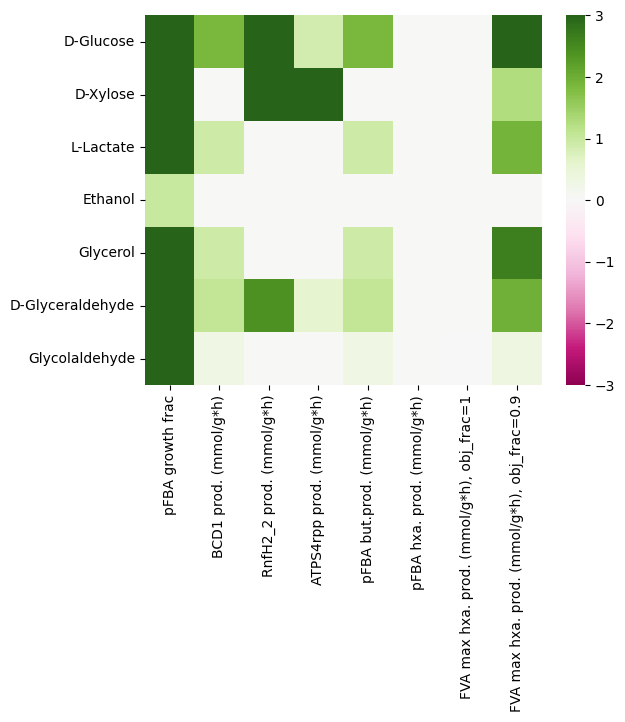

In [485]:
plot_production(model_new,RNF=True)

### Without Rnf

SC1_media_min_growth    0.000093
SC1_media_but_prod      0.000000
SC1_media_hxa_prod      0.000000
SC1_media_R_BCD1        0.000000
SC1_media_R_ATPS4rpp    0.000239
SC1_media_R_RnfH2_2     0.000000
dtype: float64
0.0
0.0
0.0
0.0
0.0
0.0
0.0


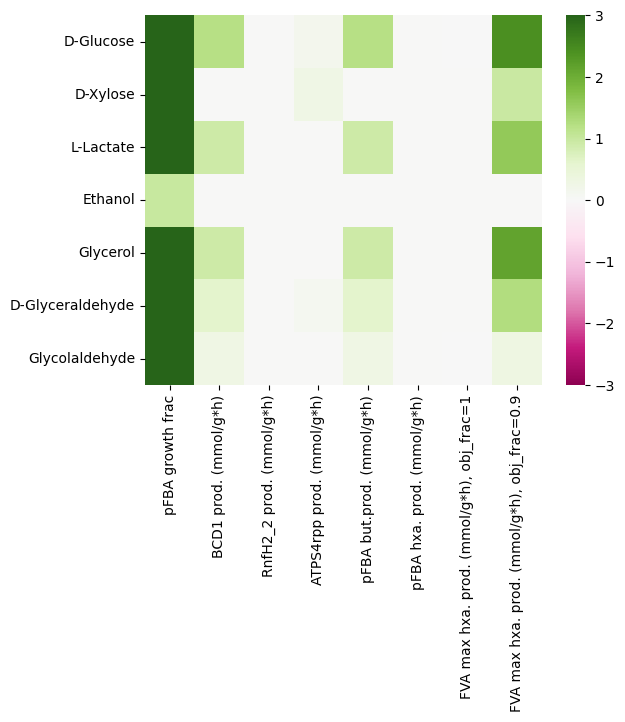

In [486]:
model_new.reactions.R_RnfH2_2.lb=0
model_new.reactions.R_RnfH2_2.ub=0


plot_production(model_new,RNF=True)

**Manipulated model that should be able to consume ethanol, but it's not doing it**

In [512]:
reaction_scores = pd.read_csv("../output/Caproicproducens_CH14_bin_0/model_results_detailed/CH14_bin_0_no_constraints_reaction_scores.tsv",sep="\t")

reaction_scores[reaction_scores.reaction=="R_ACALD"]

,reaction,GPR,score,normalized_score


In [513]:
reaction_scores[reaction_scores.reaction.str.contains("R_ETOH")]

,reaction,GPR,score,normalized_score
420,R_ETOHtrpp,spontaneous,0.0,0.0


In [514]:
model_new = reframed.load_cbmodel("../output/GEMs/GEMs_final/CH14-bin.0.xml")

model_new_copy = model_new.copy()

In [515]:
model_new_copy.add_metabolite(copy.copy(model_uni.metabolites.M_etoh_e))
model_new_copy.add_reaction(copy.copy(model_uni.reactions.R_ETOHt))
model_new_copy.add_reaction(copy.copy(model_uni.reactions.R_EX_etoh_e))


In [516]:
model_new_copy.add_reaction(copy.copy(model_uni.reactions.R_ACALD))


In [521]:
constrained_medium_env_cp = constrained_medium_env.copy()
constrained_medium_env_cp["R_EX_etoh_e"]=(-10,0)


constrained_medium_env_cp.apply(model_new_copy,warning=False,inplace=True)
sol = reframed.pFBA(model_new_copy)
print(sol.values["R_Growth"])
sol.show_values(pattern="R_EX_",sort=True,abstol=1e-3)

0.0007538848227437075
R_EX_etoh_e  -0.150237
R_EX_so4_e   -0.0213168
R_EX_cys__L_e -0.01
R_EX_nh4_e    0.00156088
R_EX_h2s_e    0.0311279
R_EX_hxa_e    0.0340565
R_EX_h_e      0.0358226
R_EX_ac_e     0.0467146
R_EX_h2_e     0.068113
R_EX_h2o_e    0.0839861


In [527]:
sol.show_metabolite_turnover(model_new,"M_hxcoa_c")

M_hxcoa_c     0.0340565


In [531]:
sol.show_metabolite_balance("M_fdxrd_c",model_new,equations=True)

[ --> o ] R_BCD3        0.068113 	M_hx2coa_c + 2.0 M_nadh_c + 2.0 M_fdxo_2_2_c <-> M_hxcoa_c + 2.0 M_nad_c + 2.0 M_fdxrd_c
[ --> o ] R_BCD1        0.068113 	M_b2coa_c + 2.0 M_nadh_c + 2.0 M_fdxo_2_2_c <-> M_btcoa_c + 2.0 M_nad_c + 2.0 M_fdxrd_c
[ <-- o ] R_FNRR3_1    -0.136226 	2.0 M_fdxo_2_2_c + M_h2_c <-> 2.0 M_fdxrd_c + 2.0 M_h_c


In [520]:
constrained_medium_env_cp = constrained_medium_env.copy()
constrained_medium_env_cp["R_EX_lac__L_e"]=(-10,0)


constrained_medium_env_cp.apply(model_new_copy,warning=False,inplace=True)
sol = reframed.pFBA(model_new_copy)
print(sol.values["R_Growth"])
sol.show_values(pattern="R_EX_",sort=True,abstol=1e-3)

0.08057991722761601
R_EX_lac__L_e -10
R_EX_h_e     -4.35479
R_EX_so4_e   -1.52316
R_EX_nh4_e   -0.892025
R_EX_pi_e    -0.0794593
R_EX_k_e     -0.0157286
R_EX_cys__L_e -0.01
R_EX_but_e    0.914658
R_EX_h2o_e    1.40318
R_EX_h2s_e    1.51298
R_EX_ac_e     6.96546
R_EX_co2_e    9.0037
R_EX_h2_e     9.85403


In [518]:
EGC.EGC_identifier(model_new_copy,print_results=False)

There are NO energy producing cycles in the model


{}

In [519]:
reframed.FVA(model_new_copy,reactions=["R_EX_etoh_e","R_ETOHt","R_ALCD2x","R_ACALD"],obj_frac=1)

{'R_EX_etoh_e': [-10.0, -0.12045410853135344],
 'R_ETOHt': [0.12045410853135306, 10.0],
 'R_ALCD2x': [0.12045410853135344, 10.0],
 'R_ACALD': [0.12045410853135344, 9.999999999999927]}

SC1_media_min_growth    0.000107
SC1_media_but_prod      0.001179
SC1_media_hxa_prod      0.000000
SC1_media_R_BCD1        0.001179
SC1_media_R_ATPS4rpp    0.002442
SC1_media_R_RnfH2_2     0.009768
dtype: float64
0.0
0.0
0.0
0.03405648609617796
0.0
0.0
0.0


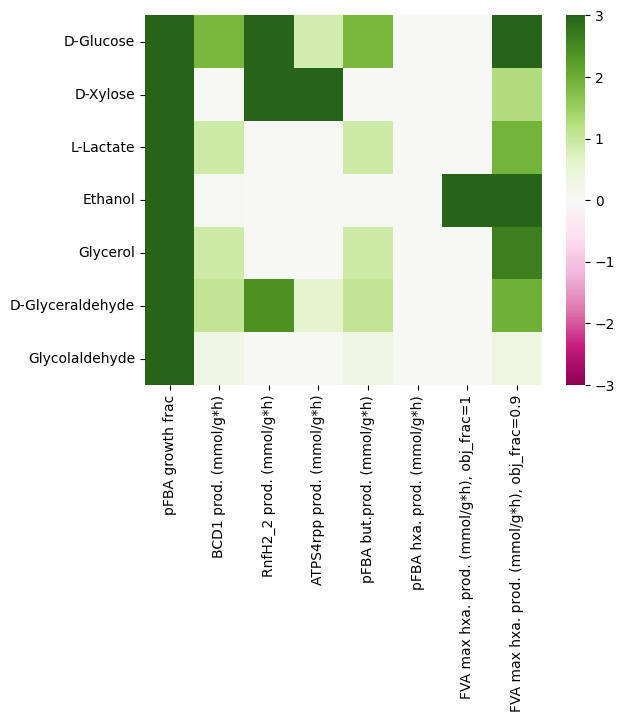

In [495]:
plot_production(model_new_copy,RNF=True)

##### Save model

In [507]:
model_new = reframed.load_cbmodel("../output/GEMs/GEMs_final/CH14-bin.0.xml")

In [508]:
reframed.save_cbmodel(model_new,"../output/GEMs_CD_X/CH14-bin.0.xml")

## CH14-bin.1 (Lacrimispora)

In [357]:
model_lac = reframed.load_cbmodel("../output/GEMs/GEMs_final/CH14-bin.1.xml")

In [358]:
constrained_medium_env.apply(model_lac,warning=False,inplace=True)
sol = reframed.pFBA(model_lac)

SC1_media_min_growth = sol.values["R_Growth"]
SC1_media_but_prod = sol.values["R_EX_but_e"]


In [359]:
SC1_media_min_growth

0.026112947575043

In [360]:
SC1_media_but_prod

0.0

In [361]:
results_SC1 = {}

for met in carbon_sources:
    results_SC1[met]={}
    
    constrained_medium_env_cp = constrained_medium_env.copy()
    constrained_medium_env_cp["R_EX_"+met+"_e"]=(-10,0)
    constrained_medium_env_cp.apply(model_lac,warning=False,inplace=True)

    sol = reframed.pFBA(model_lac)
    sol_fva = reframed.FVA(model_lac,obj_frac=1,reactions=["R_EX_ac_e","R_EX_but_e"])
    sol_fva_0_9 = reframed.FVA(model_lac,obj_frac=0.9,reactions=["R_EX_ac_e","R_EX_but_e"])
    
    results_SC1[met]["pFBA growth increase frac"]=(sol.values["R_Growth"]/SC1_media_min_growth)
    results_SC1[met]["pFBA but. prod. (mmol/g*h)"]=sol.values["R_EX_but_e"] if sol.values["R_EX_but_e"]>1e-6 else 0
    results_SC1[met]["FVA max but. prod. (mmol/g*h), obj_frac=1"]=sol_fva["R_EX_but_e"][1]
    results_SC1[met]["FVA max but. prod. (mmol/g*h), obj_frac=0.9"]=sol_fva_0_9["R_EX_but_e"][1]
    

In [362]:
pd.DataFrame(results_SC1).T

,pFBA growth increase frac,pFBA but. prod. (mmol/g*h),"FVA max but. prod. (mmol/g*h), obj_frac=1","FVA max but. prod. (mmol/g*h), obj_frac=0.9"
glc__D,13.707722,0.0,-0.000000,0.958838
xyl__D,11.589769,0.0,-0.000000,0.810689
lac__L,1.000000,0.0,-0.000000,0.069915
etoh,3.752930,0.0,-0.000000,0.161333
glyc,7.353861,0.0,-0.000000,0.514393
glyald,7.353861,0.0,-0.000000,0.514393
gcald,0.000000,0.0,0.693932,0.693932


In [363]:
constrained_medium_env.apply(model_lac,warning=False,inplace=True)
sol = reframed.pFBA(model_lac)
print(sol.values["R_Growth"])
sol.show_values(pattern="R_EX_",sort=True)#abstol=1e-3)

0.026112947575043
R_EX_h2o_e   -0.676629
R_EX_nh4_e   -0.316847
R_EX_xylan4_e -0.0923077
R_EX_so4_e   -0.0486008
R_EX_xylan8_e -0.0461538
R_EX_pi_e    -0.0257498
R_EX_cys__L_e -0.01
R_EX_k_e     -0.00509706
R_EX_mg2_e   -0.00022653
R_EX_fe3_e   -0.00020389
R_EX_fe2_e   -0.000175348
R_EX_ca2_e   -0.000135918
R_EX_cl_e    -0.000135918
R_EX_nac_e   -5.94853e-05
R_EX_cu2_e   -1.85141e-05
R_EX_mn2_e   -1.8044e-05
R_EX_pnto__R_e -1.50411e-05
R_EX_zn2_e   -8.90452e-06
R_EX_cobalt2_e -2.61129e-06
R_EX_thm_e    0.00863221
R_EX_4hba_e   0.00863803
R_EX_gcald_e  0.0086555
R_EX_h2s_e    0.043424
R_EX_h_e      1.16369
R_EX_ac_e     1.1637
R_EX_co2_e    1.20761
R_EX_h2_e     1.75254


In [364]:
reframed.FVA(model=model_lac,reactions=["R_EX_etoh_e"],obj_frac=1)

{'R_EX_etoh_e': [0.0, -0.0]}

In [365]:
reframed.FVA(model=model_lac,reactions=["R_EX_etoh_e"],obj_frac=0.9)

{'R_EX_etoh_e': [0.0, 0.3146193496712376]}

In [366]:
reframed.FVA(model=model_lac,reactions=["R_EX_glyald_e"],obj_frac=1)

{'R_EX_glyald_e': [0.0, -0.0]}

In [367]:
reframed.FVA(model=model_lac,reactions=["R_EX_glyald_e"],obj_frac=0.9)

{'R_EX_glyald_e': [0.0, 0.10487311655708181]}

In [368]:
reframed.FVA(model=model_lac,reactions=["R_EX_gua_e"],obj_frac=1)

{'R_EX_gua_e': [0.0, -0.0]}

In [369]:
reframed.FVA(model=model_lac,reactions=["R_EX_gua_e"],obj_frac=0.9)

{'R_EX_gua_e': [0.0, 0.016591278627310205]}

In [370]:
reframed.FVA(model=model_lac,reactions=["R_BCD1"],obj_frac=0.9)

{'R_BCD1': [-inf, 0.0699154110380552]}

## CH14-bin.2 (Robinsoniella) - Wood-Ljungdal pathway

In [ ]:
model_rob = reframed.load_cbmodel("../output/GEMs/GEMs_final/CH14-bin.2.xml")

In [ ]:
constrained_medium_env["R_EX_ura_e"]=(-1000,0)
constrained_medium_env.apply(model_rob,warning=False,inplace=True)

sol = reframed.pFBA(model_rob)

SC1_media_min_growth = sol.values["R_Growth"]
SC1_media_but_prod = sol.values["R_EX_but_e"]


In [ ]:
SC1_media_min_growth

0.01256818491884212

In [ ]:
SC1_media_but_prod

0.0

In [ ]:
results_SC1 = {}

for met in carbon_sources:
    results_SC1[met]={}
    
    constrained_medium_env_cp = constrained_medium_env.copy()
    constrained_medium_env_cp["R_EX_"+met+"_e"]=(-10,0)
    constrained_medium_env_cp.apply(model_rob,warning=False,inplace=True)

    sol = reframed.pFBA(model_rob)
    sol_fva = reframed.FVA(model_rob,obj_frac=1,reactions=["R_EX_ac_e","R_EX_but_e","R_EX_hxa_e"])
    sol_fva_0_9 = reframed.FVA(model_rob,obj_frac=0.9,reactions=["R_EX_ac_e","R_EX_but_e","R_EX_hxa_e"])
    
    results_SC1[met]["pFBA growth increase %"]=(sol.values["R_Growth"]/SC1_media_min_growth -1)*100
    results_SC1[met]["pFBA but. prod. (mmol/g*h)"]=sol.values["R_EX_but_e"] if sol.values["R_EX_but_e"]>1e-6 else 0
    results_SC1[met]["FVA max but. prod. (mmol/g*h), obj_frac=1"]=sol_fva["R_EX_but_e"][1]
    results_SC1[met]["FVA max but. prod. (mmol/g*h), obj_frac=0.9"]=sol_fva_0_9["R_EX_but_e"][1]
    
    results_SC1[met]["pFBA growth increase %"]=(sol.values["R_Growth"]/SC1_media_min_growth -1)*100
    results_SC1[met]["pFBA hxa. prod. (mmol/g*h)"]=sol.values["R_EX_hxa_e"] if sol.values["R_EX_hxa_e"]>1e-6 else 0
    results_SC1[met]["FVA max hxa. prod. (mmol/g*h), obj_frac=1"]=sol_fva["R_EX_hxa_e"][1]
    results_SC1[met]["FVA max hxa. prod. (mmol/g*h), obj_frac=0.9"]=sol_fva_0_9["R_EX_hxa_e"][1]
    

In [ ]:
pd.DataFrame(results_SC1).T

,pFBA growth increase %,pFBA but. prod. (mmol/g*h),"FVA max but. prod. (mmol/g*h), obj_frac=1","FVA max but. prod. (mmol/g*h), obj_frac=0.9",pFBA hxa. prod. (mmol/g*h),"FVA max hxa. prod. (mmol/g*h), obj_frac=1","FVA max hxa. prod. (mmol/g*h), obj_frac=0.9"
glc__D,2586.892431,0.0,8.952838e-13,3.137782,0.0,-0.0,-0.0
xyl__D,2155.870726,0.0,-0.000000e+00,2.636379,0.0,-0.0,-0.0
lac__L,0.000000,0.0,-0.000000e+00,0.126030,0.0,-0.0,-0.0
etoh,0.000000,0.0,-0.000000e+00,0.126030,0.0,-0.0,-0.0
glyc,0.000000,0.0,-0.000000e+00,0.126030,0.0,-0.0,-0.0
glyald,0.000000,0.0,-0.000000e+00,0.126030,0.0,-0.0,-0.0
gcald,0.003959,0.0,-0.000000e+00,0.126031,0.0,-0.0,-0.0


#### Found in Maria's analysis

**(Not in BIGG!) acetyl-CoA decarbonylase/synthase complex [EC:2.3.1.-] [RN:R10243]**

In [248]:
model_rob.metabolites.M_thf_c

5,6,7,8-Tetrahydrofolate

**carbon-monoxide dehydrogenase [EC:1.2.7.4] [RN:R07157] (https://www.metanetx.org/equa_info/MNXR149765)**

In [249]:
model_rob.reactions.R_COCO2_1

R_COCO2_1: M_co_c + M_h2o_c + 2.0 M_fdxo_2_2_c <-> M_co2_c + 2.0 M_fdxrd_c + 2.0 M_h_c

**methylenetetrahydrofolate reductase (NADPH) [EC:1.5.1.20] [RN:R07168]**

In [250]:
model_rob.reactions.R_MTHFR2

R_MTHFR2: 2.0 M_h_c + M_mlthf_c + M_nadh_c --> M_5mthf_c + M_nad_c

**(Not found in bigg!) acetyl-CoA synthase [EC:2.3.1.169] [RN:R08433]**

**(not found in bigg!) 5-methyltetrahydrofolate corrinoid/iron sulfur protein methyltransferase [EC:2.1.1.258] [RN:R02289]**

#### Not found in Maria's analysis

**methylenetetrahydrofolate dehydrogenase (NADP+) / methenyltetrahydrofolate cyclohydrolase [EC:1.5.1.5 3.5.4.9] [RN:R01655 R01220]**

In [251]:
model_rob.reactions.R_MTHFD

R_MTHFD: M_mlthf_c + M_nadp_c <-> M_methf_c + M_nadph_c

In [252]:
model_rob.reactions.R_MTHFD.gpr

G_gene4537

**formate--tetrahydrofolate ligase [EC:6.3.4.3] [RN:R00943]**

In [253]:
"R_FTHFLi" in model_rob.reactions

False

**formate dehydrogenase [EC:1.17.1.10] [RN:R00134]  (Bigg eq: http://bigg.ucsd.edu/universal/reactions/FDH and http://bigg.ucsd.edu/universal/reactions/FDH6r)**

In [254]:
"R_FDH" in model_rob.reactions

False

In [255]:
"R_FDH6r" in model_rob.reactions

False

In [256]:
model_rob.get_metabolite_consumers("M_co_c")

['R_COCO2_1']

In [257]:
model_rob.get_metabolite_producers("M_co_c")

['R_Cotpp']

## CH14-bin.4 (Desulfovibrio) - 

In [288]:
model_de = reframed.load_cbmodel("../output/GEMs/GEMs_final/CH14-bin.4.xml")

In [289]:
model_de.get_metabolite_reactions("M_xyl__D_e")

['R_ARApts', 'R_XYLabc', 'R_XYLt', 'R_EX_xyl__D_e']

In [290]:
model_de.reactions.R_XYLabc

R_XYLabc: M_atp_c + M_h2o_c + M_xyl__D_e --> M_adp_c + M_h_c + M_pi_c + M_xyl__D_c

In [291]:
model_de.reactions.R_XYLabc.gpr

G_gene1712

In [292]:
model_de.reactions.R_XYLt

R_XYLt: M_xyl__D_e <-> M_xyl__D_c

In [293]:
model_de.reactions.R_XYLt.gpr

In [294]:
model_de.get_metabolite_reactions("M_xyl__D_c")

['R_XYLabc', 'R_XYLt']

In [295]:
model_de.reactions.R_ARApts

R_ARApts: M_pep_c + M_xyl__D_e --> M_pyr_c + M_xu5p__D_c

In [275]:
model_de.reactions.R_ARApts.gpr

In [296]:
model_de = reframed.load_cbmodel("../output/GEMs/GEMs_final_desulfo/CH14-bin.4.xml")

In [297]:
reframed.save_cbmodel(model_de,"../output/GEMs_CD_X/CH14-bin.4.xml")

In [281]:
communities_99_SC1_X = pd.read_csv("../output/steadiercom_sample_0.1.3/communities_99_SC1_X.tsv",sep="\t",header=None)
communities_99_SC1_X

,0,1,2
0,CD_X,CH14-bin.1,0.547073
1,CD_X,CH14-bin.2,0.188311
2,CD_X,CH14-bin.4,0.027418
3,CD_X,CH14-bin.0,0.156175
4,CM_X,CH9-bin.0,0.704519
5,CM_X,CH9-bin.6,0.096620
6,CM_X,CH9-bin.5,0.031183
7,CM_X,CH9-bin.1,0.022605
8,CM_X,CH9-bin.2,0.020385
9,CM_X,CH9-bin.4,0.019066


In [282]:
communities_99_CD_X = communities_99_SC1_X[communities_99_SC1_X[0]=="CD_X"]
communities_99_CD_X

,0,1,2
0,CD_X,CH14-bin.1,0.547073
1,CD_X,CH14-bin.2,0.188311
2,CD_X,CH14-bin.4,0.027418
3,CD_X,CH14-bin.0,0.156175


In [298]:
communities_99_CD_X.to_csv("../output/GEMs_CD_X/communities_99_CD_X.tsv",sep="\t",header=None,index=None)